10/23/10 Note

The implementation of CV is in `sequences Exploration.ipynb`

Check

The following uses XGBoost + target encoder all census features
1. Fixed + Distance >> 0.63    vs .53
2. Fixed >> 0.51    vs  .39
3. Distance  >> 0.62    vs .48
4. No sequence >>  0.49  vs .35
5. dwelling >> 0.51. vs .39
6. dwelling + distance >> 0.65  vs  .53   +++++**BEST wo CV**+++++
7. dwelling + distance ** with ordinal encoded `CENSUS_dwelling_num` >> 0.63   vs 0.60  ++++**BEST with CV**++++
8. dwelling + distance ** with target encoded `CENSUS_dwelling_num` >> 0.60. vs .47  

**Conclusion::: dwelling + distance + (all target encoded) + not include `CENSUS_dwelling_num` is best**



====== include enumerator data ======
9. dwelling + distance + \[enu_num + enu_date + ancestry_ref\]  >> 0.64  vs 0.54
10. \[enu_num + enu_date + ancestry_ref\]  >> 0.50   vs. 0.40
11. enu seq >> 0.49  vs. 0.41
12. dwelling + distance + enu seq >> 0.62    vs. 52
13. enum_dist seq + dwelling + distance + fixed >> 0.67   vs  .53 +++++ **BEST** +++++
14. enum_dist seq only >> 0.66  vs  .58  +++++ **BEST w CV** +++++



**Conclusion:: a bit improvement when include enum_dist sequence**

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from interpolation import CensusData, sequences, BlockInterpolator, CentroidInterpolator, archive, interpolation
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

### Notebook Summary
**Goal**: Determine which types of sequences work best for centroid interpolation\
**Problem**: Sequences add a level of geographic association to census records, but how should they be created and what combinations should we use\
**Method**: Create multiple sequences based on different criteria\
   - distance: Created based on maximum distance between consecutive known dwellings\
   - fixed: Set number of dwellings in a sequence\
   - dwelling: Based on dwelling number from census data (order of enumeration of a single enumerator (presumed)\
   - enumerator: Sequences of dwellings visited by a single enumerator on a single day\
   - enumerator_dist: Enumerator sequences divided by distance when consecutive known sequences are greater than a maximum distance\

**In this notebooks**: Experiment with different sequence combinations, attempt to determine which one works best\

In [2]:
#Change these values to rerun the notebook
filled_1850 = pd.read_csv("../../data/dwelling_filled_sum_1850_mn_v01.csv")
cd_1850 = pd.read_csv("../../data/cd_1850_XYupdate.csv") #For calculating centroids
filled_1850.rename(columns = {"CENSUS_WARD_NUM":"Ward_Num", "CENSUS_SERIALP":"CENSUS_SERIALB", "BLOCK_NUM":"block_num", "CENSUS_REEL_HOUSEHOLD":"CENSUS_REEL", "CENSUS_SEX":"CENSUS_SEXB", "CENSUS_PAGENO_HOUSEHOLD":"CENSUS_PAGENUM", "CENSUS_RACE":"CENSUS_RACEB", "CD_X":"cd_X", "CD_Y":"cd_Y"}, inplace = True)
ward_col = "Ward_Num"
dwelling_col = "dwelling_id"
dwelling_col_num = "CENSUS_DWELLING_NUM"
block_col = "block_num"
x_col = "cd_X"
y_col = "cd_Y"
pagenum = "CENSUS_PAGENNO"

#### With both fixed length and distance sequences

In [3]:
#set clustering algo -- this is to make sure that the same clustering algorithm is used
#for each model, to ensure that testing is accurate
#note fitting before hand won't work for all types of clustering, for example, with agglomerative
#clustering this isn't going to work because the algorithm doesn't have a predict method
block_centroids = {ward:{block:interpolation.make_centroid(df_block[x_col], df_block[y_col]) for block, df_block in df.groupby(block_col)} for ward,df in cd_1850.groupby(ward_col)}

In [4]:
census_data = CensusData(filled_1850, ward_col=ward_col, dwelling_col=dwelling_col, block_col =  block_col, x_col = x_col, y_col = y_col, pagenum = pagenum)
census_data.apply_sequencing(fixed = True, distance = True)

In [5]:
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL", "CENSUS_ID", "sequence_order_enum", 'CENSUS_DWELLING_SEQ', "fixed_seq"]
block_boost = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL", "CENSUS_ID", "sequence_order_enum", 'CENSUS_DWELLING_SEQ', "fixed_seq"])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 50))])

In [33]:
interpolate_sequences = CentroidInterpolator(census_data, 10, block_boost, all_cols, KMeans(5), block_centroids)

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


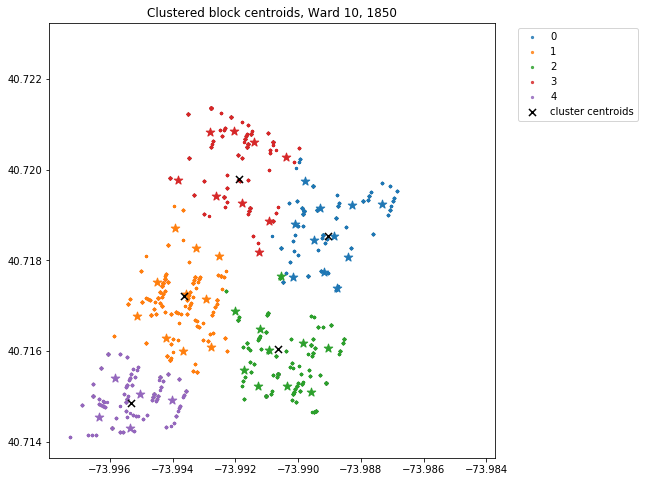

In [34]:
score, model = interpolate_sequences.kmeans_best(5)
interpolate_sequences.set_clustering_algo(model)
interpolate_sequences.apply_clustering(algo_fit = True)
interpolate_sequences.clustervis(kmeans = True)

In [35]:
train,test = interpolate_sequences.stratified_train_test()
interpolate_sequences.train_test_model(train, test)

(array([182., 115.,  31.,  11.,   3.,   1.,   0.,   0.,   0.,   1.]),
 array([ 2. , 11.7, 21.4, 31.1, 40.8, 50.5, 60.2, 69.9, 79.6, 89.3, 99. ]),
 <a list of 10 Patch objects>)

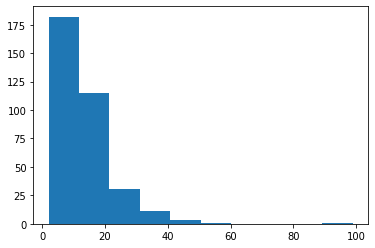

In [36]:
plt.hist(train.dwelling_id.value_counts())

In [37]:
print("Training score:",interpolate_sequences.train_score)
print("Test score:", interpolate_sequences.test_score)

Training score: 1.0
Test score: 0.618380062305296


In [46]:
## Cross validation
interpolate_sequences.cross_validate_model(k=10)
print('Cross Validation')
print("avg Training score:", np.array(interpolate_sequences.train_score).mean())
print('Test score:', interpolate_sequences.test_score)
print("avg Test score:", np.array(interpolate_sequences.test_score).mean())

Cross Validation
avg Training score: 1.0
Test score: [0.618380062305296, 0.5165562913907285, 0.50201126307321, 0.5066981875492513, 0.5167620605069502, 0.57476231633535, 0.5251690458302029, 0.600174978127734, 0.611659192825112, 0.5336065573770492]
avg Test score: 0.5505779955320884


#### With only fixed length sequences

In [29]:
census_data.apply_sequencing(fixed = True)
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL", 'CENSUS_DWELLING_SEQ', "fixed_seq"]
block_boost = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ', "fixed_seq"])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 50))])
interpolate_fixed = CentroidInterpolator(census_data, 10, block_boost, all_cols, KMeans(5), block_centroids)

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


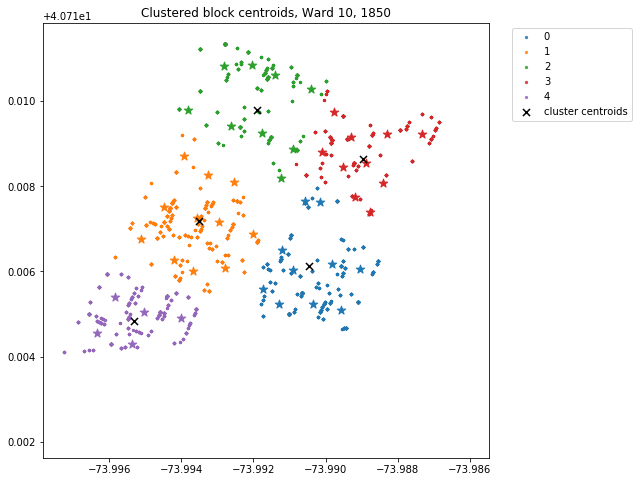

In [30]:
score, model = interpolate_fixed.kmeans_best(5)
interpolate_fixed.set_clustering_algo(model)
interpolate_fixed.apply_clustering(algo_fit = True)
interpolate_fixed.clustervis(kmeans = True)

In [31]:
train,test = interpolate_fixed.stratified_train_test()
interpolate_fixed.train_test_model(train, test)

In [32]:
print("Training score:",interpolate_fixed.train_score)
print("Test score:", interpolate_fixed.test_score)

Training score: 1.0
Test score: 0.5132978723404256


In [33]:
## Cross validation
interpolate_fixed.cross_validate_model(k=10)
print('Cross Validation')
print("avg Training score:", np.array(interpolate_fixed.train_score).mean())
print('Test score:', interpolate_fixed.test_score)
print("avg Test score:", np.array(interpolate_fixed.test_score).mean())

Cross Validation
avg Training score: 1.0
Test score: [0.5132978723404256, 0.36893203883495146, 0.4134438305709024, 0.3993055555555556, 0.43541033434650456, 0.3587140439932318, 0.35315645013723695, 0.4540901502504174, 0.2748091603053435, 0.31651749389747763]
avg Test score: 0.38876769302320474


#### With only distance length sequences

In [34]:
census_data.apply_sequencing(distance = True)
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL","sequence_order_enum", 'CENSUS_DWELLING_SEQ']
block_boost = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",  "sequence_order_enum", 'CENSUS_DWELLING_SEQ'])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 50))])

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


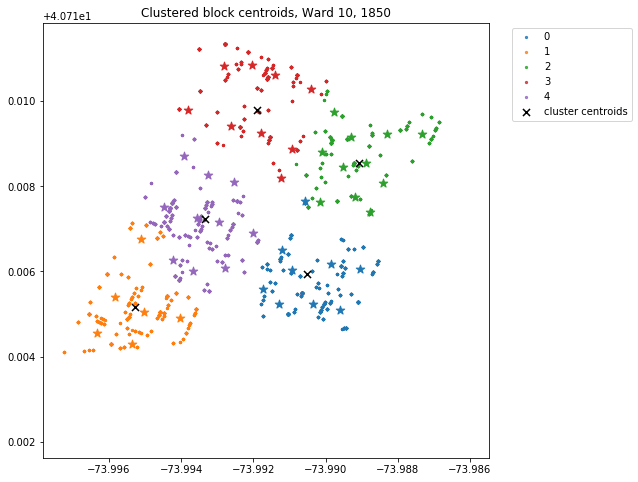

In [35]:
interpolate_distance = CentroidInterpolator(census_data, 10, block_boost, all_cols, KMeans(5), block_centroids)
score, model = interpolate_distance.kmeans_best(5)
interpolate_distance.set_clustering_algo(model)
interpolate_distance.apply_clustering(algo_fit = True)
interpolate_distance.clustervis(kmeans = True)

In [36]:
train,test = interpolate_distance.stratified_train_test()
interpolate_distance.train_test_model(train, test)

In [37]:
print("Training score:",interpolate_distance.train_score)
print("Test score:", interpolate_distance.test_score)

Training score: 1.0
Test score: 0.6294498381877023


In [38]:
## Cross validation
interpolate_distance.cross_validate_model(k=10)
print('Cross Validation')
print("avg Training score:", np.array(interpolate_distance.train_score).mean())
print('Test score:', interpolate_distance.test_score)
print("avg Test score:", np.array(interpolate_distance.test_score).mean())

Cross Validation
avg Training score: 1.0
Test score: [0.6294498381877023, 0.5164744645799012, 0.4535211267605634, 0.5016339869281046, 0.4407319013524264, 0.456437933693138, 0.38762214983713356, 0.4028475711892797, 0.5237329042638778, 0.4853448275862069]
avg Test score: 0.4797796704378334


#### Without sequences

In [39]:
census_data.no_seq()

In [40]:
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB","CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ']
block_boost = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ'])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 50))])

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


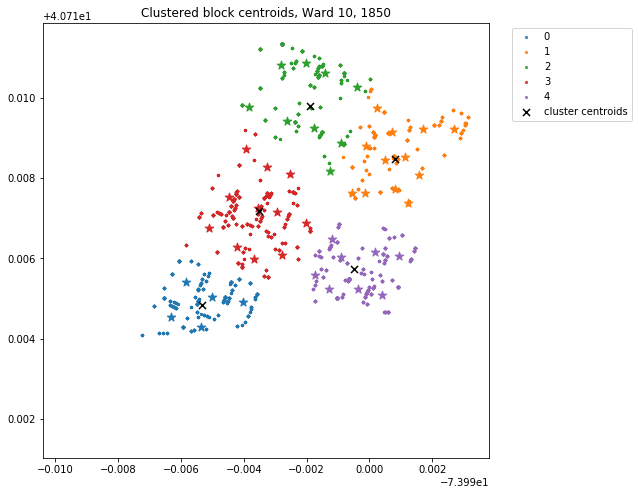

In [41]:
interpolate_noseq = CentroidInterpolator(census_data, 10, block_boost, all_cols, KMeans(5), block_centroids)
score, model = interpolate_noseq.kmeans_best(5)
interpolate_noseq.set_clustering_algo(model)
interpolate_noseq.apply_clustering(algo_fit = True)
interpolate_noseq.clustervis(kmeans = True)

In [42]:
train,test = interpolate_noseq.stratified_train_test()
interpolate_noseq.train_test_model(train, test)

In [43]:
print("Training score:",interpolate_noseq.train_score)
print("Test score:", interpolate_noseq.test_score)

Training score: 1.0
Test score: 0.495114006514658


In [44]:
## Cross validation
interpolate_noseq.cross_validate_model(k=10)
print('Cross Validation')
print("avg Training score:", np.array(interpolate_noseq.train_score).mean())
print('Test score:', interpolate_noseq.test_score)
print("avg Test score:", np.array(interpolate_noseq.test_score).mean())

Cross Validation
avg Training score: 1.0
Test score: [0.495114006514658, 0.4019933554817276, 0.29084041548630785, 0.304857621440536, 0.36253252385082396, 0.33564614050303554, 0.3008573655494934, 0.3814055636896047, 0.40106141015921154, 0.3166268894192522]
avg Test score: 0.3590935292094651


#### With dwelling_col_num sequence id only

In [45]:
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB","CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ', "dwelling_seq_id"]
block_boost = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ', "dwelling_seq_id"])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 50))])

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


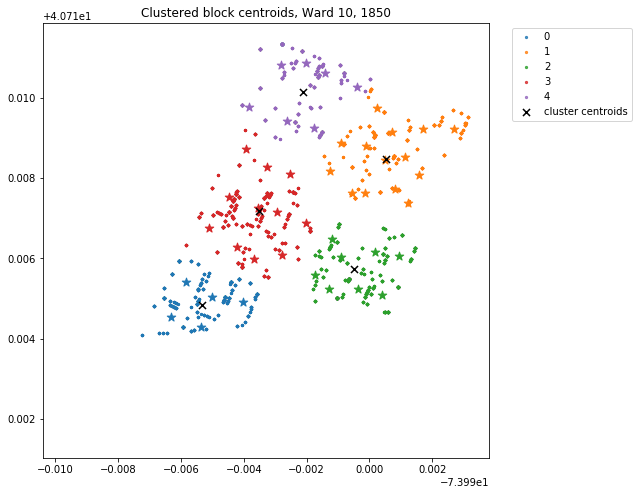

In [46]:
census_data.apply_sequencing(dwelling = True)
interpolate_dwell = CentroidInterpolator(census_data, 10, block_boost, all_cols, KMeans(5), block_centroids)
score, model = interpolate_dwell.kmeans_best(5)
interpolate_dwell.set_clustering_algo(model)
interpolate_dwell.apply_clustering(algo_fit = True)
interpolate_dwell.clustervis(kmeans = True)

In [47]:
train,test = interpolate_dwell.stratified_train_test()
interpolate_dwell.train_test_model(train, test)

In [48]:
print("Training score:",interpolate_dwell.train_score)
print("Test score:", interpolate_dwell.test_score)

Training score: 1.0
Test score: 0.5187445510026155


In [49]:
## Cross validation
interpolate_dwell.cross_validate_model(k=10)
print('Cross Validation')
print("avg Training score:", np.array(interpolate_dwell.train_score).mean())
print('Test score:', interpolate_dwell.test_score)
print("avg Test score:", np.array(interpolate_dwell.test_score).mean())

Cross Validation
avg Training score: 1.0
Test score: [0.5187445510026155, 0.3468507333908542, 0.40630182421227196, 0.30097087378640774, 0.4101633393829401, 0.3153904473085671, 0.3601593625498008, 0.4448246364414029, 0.4111014744145707, 0.4021121039805037]
avg Test score: 0.39166193464699345


#### With dwelling_col_num sequence id and distance sequences

In [50]:
#I think dwelling num would need to be preprocessed
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB","CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ', "sequence_order_enum", "sequence_id", "dwelling_seq_id"]
block_boost = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ', "sequence_order_enum", "sequence_id", "dwelling_seq_id"])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 50))])

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


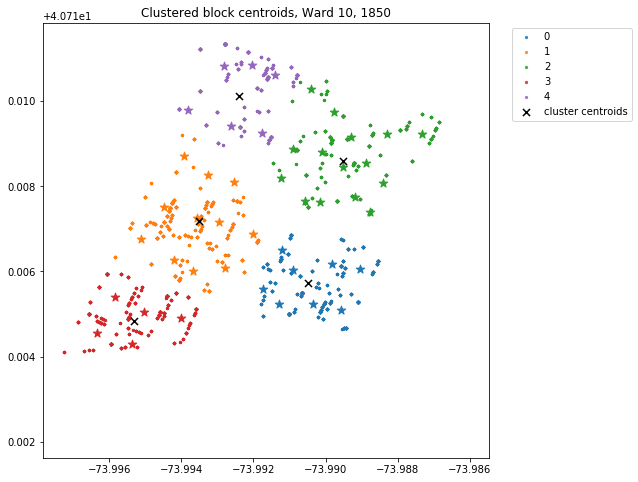

In [51]:
census_data.apply_sequencing(distance = True, dwelling = True)
interpolate_dwell = CentroidInterpolator(census_data, 10, block_boost, all_cols, KMeans(5), block_centroids)
score, model = interpolate_dwell.kmeans_best(5)
interpolate_dwell.set_clustering_algo(model)
interpolate_dwell.apply_clustering(algo_fit = True)
interpolate_dwell.clustervis(kmeans = True)

In [52]:
train,test = interpolate_dwell.stratified_train_test()
interpolate_dwell.train_test_model(train, test)

In [53]:
print("Training score:",interpolate_dwell.train_score)
print("Test score:", interpolate_dwell.test_score)

Training score: 1.0
Test score: 0.6493756003842459


In [54]:
## Cross validation
interpolate_dwell.cross_validate_model(k=10)
print('Cross Validation')
print("avg Training score:", np.array(interpolate_dwell.train_score).mean())
print('Test score:', interpolate_dwell.test_score)
print("avg Test score:", np.array(interpolate_dwell.test_score).mean())

Cross Validation
avg Training score: 1.0
Test score: [0.6493756003842459, 0.4637404580152672, 0.513267626990144, 0.5181543116490166, 0.5721877767936226, 0.4951237809452363, 0.6187845303867403, 0.5643478260869565, 0.4228993536472761, 0.5214081826831589]
avg Test score: 0.5339289447581665


#### Random Forest

In [31]:
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB","CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ', "sequence_order_enum", "sequence_id", "dwelling_seq_id"]
rf = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ', "sequence_order_enum", "sequence_id", "dwelling_seq_id"])),
                ('classifier', RandomForestClassifier(n_estimators = 400))])

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


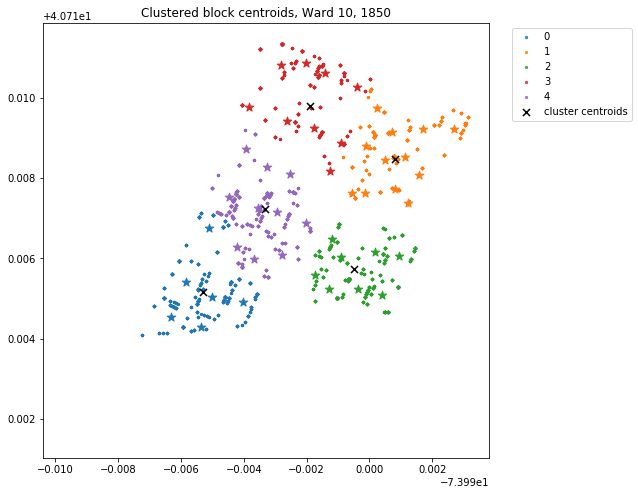

In [32]:
interpolate_rf = CentroidInterpolator(census_data, 10, rf, all_cols, KMeans(5), block_centroids)
score, model = interpolate_rf.kmeans_best(5)
interpolate_rf.set_clustering_algo(model)
interpolate_rf.apply_clustering(algo_fit = True)
interpolate_rf.clustervis(kmeans = True)

In [33]:
train,test = interpolate_rf.stratified_train_test()
interpolate_rf.train_test_model(train, test)

In [34]:
print("Training score:",interpolate_rf.train_score)
print("Test score:", interpolate_rf.test_score)

Training score: 1.0
Test score: 0.6717299578059072


#### With CENSUS_DWELLING_COL

##### Ordinal encoding of order (CENSUS_DWELLING_NUM)

In [55]:
dwellings_1850 = filled_1850.groupby([ward_col, dwelling_col], as_index = False).first()

In [56]:
#Ordinal encoding (leaving as numeric)
all_cols = ["CENSUS_DWELLING_NUM","CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB","CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ', "sequence_order_enum", "sequence_id", "dwelling_seq_id"]
ordinal_encode = make_column_transformer((OrdinalEncoder(), ['CENSUS_DWELLING_NUM']))
block_boost_ord = Pipeline([('ordinal encode', ordinal_encode),
    ('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ', "sequence_order_enum", "sequence_id", "dwelling_seq_id"])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 50))])

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


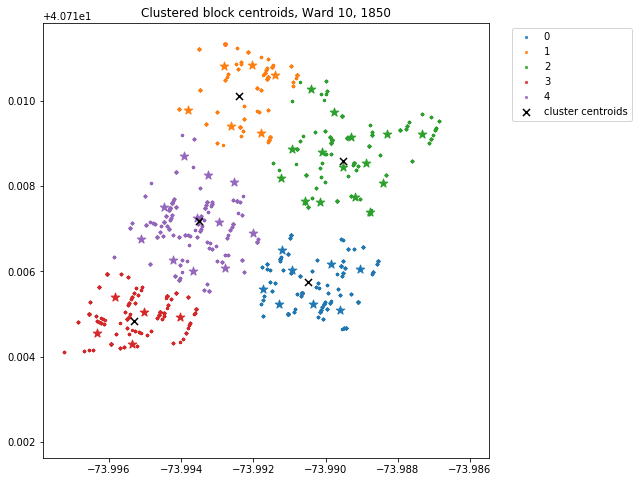

In [57]:
census_data.apply_sequencing(distance = True, dwelling = True)
interpolate_dwell_ord = CentroidInterpolator(census_data, 10, block_boost, all_cols, KMeans(5), block_centroids)
score, model = interpolate_dwell_ord.kmeans_best(5)
interpolate_dwell_ord.set_clustering_algo(model)
interpolate_dwell_ord.apply_clustering(algo_fit = True)
interpolate_dwell_ord.clustervis(kmeans = True)

In [58]:
train,test = interpolate_dwell_ord.stratified_train_test()
interpolate_dwell_ord.train_test_model(train, test)

In [59]:
print("Training score:",interpolate_dwell_ord.train_score)
print("Test score:", interpolate_dwell_ord.test_score)

Training score: 1.0
Test score: 0.6235201262825573


In [60]:
## Cross validation
interpolate_dwell_ord.cross_validate_model(k=10)
print('Cross Validation')
print("avg Training score:", np.array(interpolate_dwell_ord.train_score).mean())
print('Test score:', interpolate_dwell_ord.test_score)
print("avg Test score:", np.array(interpolate_dwell_ord.test_score).mean())

Cross Validation
avg Training score: 1.0
Test score: [0.6235201262825573, 0.49827288428324695, 0.575, 0.552652414885194, 0.6219178082191781, 0.6736292428198434, 0.600312256049961, 0.6953872932985204, 0.6490384615384616, 0.5887156644394952]
avg Test score: 0.6078446151816459


##### Target encoding of order (CENSUS_DWELLING_NUM)

In [61]:
#target encoding
all_cols = ["CENSUS_DWELLING_NUM","CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB","CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ', "sequence_order_enum", "sequence_id", "dwelling_seq_id"]
block_boost = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_DWELLING_NUM","CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ', "sequence_order_enum", "sequence_id", "dwelling_seq_id"])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 50))])

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


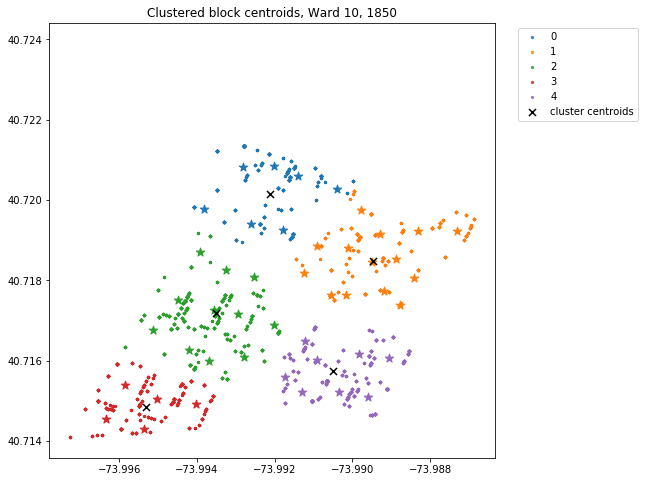

In [62]:
census_data.apply_sequencing(dwelling = True, distance = True)
interpolate_dwell_ord_enc = CentroidInterpolator(census_data, 10, block_boost, all_cols, KMeans(5), block_centroids)
score, model = interpolate_dwell_ord_enc.kmeans_best(5)
interpolate_dwell_ord_enc.set_clustering_algo(model)
interpolate_dwell_ord_enc.apply_clustering(algo_fit = True)
interpolate_dwell_ord_enc.clustervis(kmeans = True)

In [63]:
train,test = interpolate_dwell_ord_enc.stratified_train_test()
interpolate_dwell_ord_enc.train_test_model(train, test)

In [64]:
print("Training score:",interpolate_dwell_ord_enc.train_score)
print("Test score:", interpolate_dwell_ord_enc.test_score)

Training score: 1.0
Test score: 0.60431654676259


In [65]:
## Cross validation
interpolate_dwell_ord_enc.cross_validate_model(k=10)
print('Cross Validation')
print("avg Training score:", np.array(interpolate_dwell_ord_enc.train_score).mean())
print('Test score:', interpolate_dwell_ord_enc.test_score)
print("avg Test score:", np.array(interpolate_dwell_ord_enc.test_score).mean())

Cross Validation
avg Training score: 1.0
Test score: [0.60431654676259, 0.3900709219858156, 0.5510204081632653, 0.4551223934723481, 0.5230627306273062, 0.49542124542124544, 0.3509075194468453, 0.4011874469889737, 0.43671416596814755, 0.49224137931034484]
avg Test score: 0.47000647581468813


This indicates that using distance based sequences and dwelling based sequences with target encoding and without order within sequence works best. Next we'll experiment with incorporating the enumerator name and date

### Explore Enumeration and Date

In [66]:
enumerators = pd.read_csv("../../data/census_1850_enumerationDetail_mn_ward10.csv")

In [67]:
enumerators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553 entries, 0 to 552
Data columns (total 7 columns):
CENSUS_PAGENO_HOUSEHOLD    553 non-null int64
CENSUS_PAGENNO             553 non-null int64
CENSUS_WARD_NUM            553 non-null int64
CENSUS_REEL_HOUSEHOLD      553 non-null int64
CENSUS_ENUMERATOR_NUM      553 non-null int64
CENSUS_ENUMERATOR_DATE     553 non-null object
ANCESTRY_REF               553 non-null object
dtypes: int64(5), object(2)
memory usage: 30.4+ KB


In [68]:
ward10 = filled_1850[filled_1850[ward_col] == 10]
ward10_enumerators = ward10.merge(enumerators,  how = "left", left_on= "CENSUS_PAGENUM", right_on = "CENSUS_PAGENO_HOUSEHOLD")

In [69]:
census_enumerators = CensusData(ward10_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, block_col =  block_col, x_col = x_col, y_col = y_col)
census_enumerators.apply_sequencing(distance = True, dwelling = True)

#### Enumerator name, date, with distance and dwelling sequences

In [70]:
all_cols_enum = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB","CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ', "sequence_order_enum", "sequence_id", "dwelling_seq_id", "CENSUS_ENUMERATOR_NUM", "CENSUS_ENUMERATOR_DATE", "ANCESTRY_REF"]
block_boost_enum = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB","CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ', "sequence_order_enum", "sequence_id", "dwelling_seq_id", "CENSUS_ENUMERATOR_NUM", "CENSUS_ENUMERATOR_DATE", "ANCESTRY_REF"])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 50))])

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


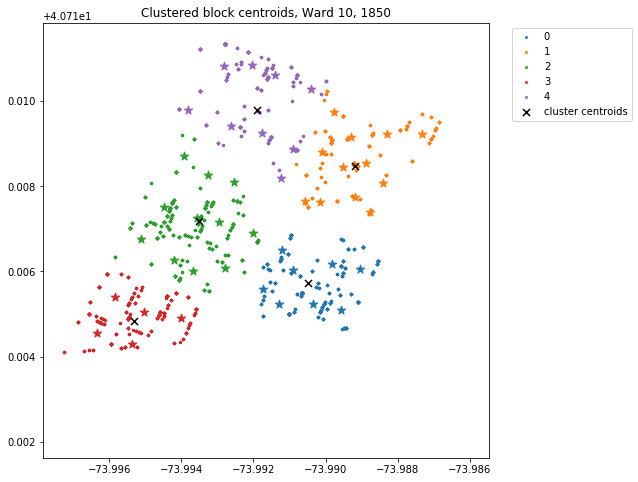

In [71]:
interpolate_enum = CentroidInterpolator(census_enumerators, 10, block_boost_enum, all_cols_enum, KMeans(5), block_centroids)
score, model = interpolate_enum.kmeans_best(5)
interpolate_enum.set_clustering_algo(model)
interpolate_enum.apply_clustering(algo_fit = True)
interpolate_enum.clustervis(kmeans = True)

In [72]:
train,test = interpolate_enum.stratified_train_test()
interpolate_enum.train_test_model(train, test)

In [73]:
print("Training score:",interpolate_enum.train_score)
print("Test score:", interpolate_enum.test_score)

Training score: 1.0
Test score: 0.6378286683630195


In [74]:
## Cross validation
interpolate_enum.cross_validate_model(k=10)
print('Cross Validation')
print("avg Training score:", np.array(interpolate_enum.train_score).mean())
print('Test score:', interpolate_enum.test_score)
print("avg Test score:", np.array(interpolate_enum.test_score).mean())

Cross Validation
avg Training score: 1.0
Test score: [0.6378286683630195, 0.5446280991735537, 0.49166666666666664, 0.4897959183673469, 0.5622743682310469, 0.5120772946859904, 0.5746924428822495, 0.5254237288135594, 0.4369406021155411, 0.6146230007616146]
avg Test score: 0.5389950790060589


#### Let's try without any sequences but with the enumeration data

In [75]:
census_enumerators = CensusData(ward10_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, block_col =  block_col, x_col = x_col, y_col = y_col)
census_enumerators.no_seq()

In [76]:
all_cols_enum = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB","CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ', "CENSUS_ENUMERATOR_NUM", "CENSUS_ENUMERATOR_DATE", "ANCESTRY_REF"]
block_boost_enum = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB","CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ', "CENSUS_ENUMERATOR_NUM", "CENSUS_ENUMERATOR_DATE", "ANCESTRY_REF"])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 50))])

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


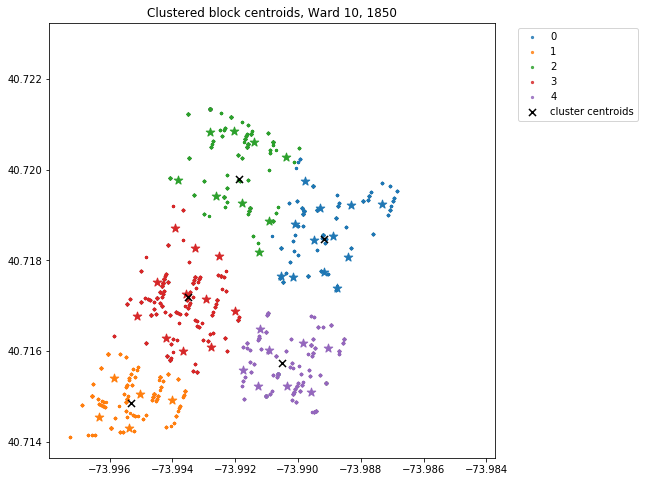

In [77]:
interpolate_enum = CentroidInterpolator(census_enumerators, 10, block_boost_enum, all_cols_enum, KMeans(5), block_centroids)
score, model = interpolate_enum.kmeans_best(5)
interpolate_enum.set_clustering_algo(model)
interpolate_enum.apply_clustering(algo_fit = True)
interpolate_enum.clustervis(kmeans = True)

In [78]:
## Cross validation
interpolate_enum.cross_validate_model(k=10)
print('Cross Validation')
print("avg Training score:", np.array(interpolate_enum.train_score).mean())
print('Test score:', interpolate_enum.test_score)
print("avg Test score:", np.array(interpolate_enum.test_score).mean())

Cross Validation
avg Training score: 1.0
Test score: [0.4780701754385965, 0.38313253012048193, 0.3721618953603159, 0.4061718098415346, 0.42950819672131146, 0.31175468483816016, 0.29651162790697677, 0.4607454401268834, 0.44122657580919933, 0.33278145695364236]
avg Test score: 0.39120643931171023


In [79]:
train,test = interpolate_enum.stratified_train_test()
interpolate_enum.train_test_model(train, test)

In [80]:
print("Training score:",interpolate_enum.train_score)
print("Test score:", interpolate_enum.test_score)

Training score: 1.0
Test score: 0.4780701754385965


#### Let's create a sequence id from enumerator number and date, and use only that as a sequence

In [81]:
census_enumerators_seq = CensusData(ward10_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, block_col =  block_col, x_col = x_col, y_col = y_col)
census_enumerators_seq.apply_sequencing(enumerator = True)

In [82]:
all_cols_enum = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB","CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ', "CENSUS_ENUMERATOR_NUM", "CENSUS_ENUMERATOR_DATE", "ANCESTRY_REF", "enum_seq"]
block_boost_enum = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB","CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ', "CENSUS_ENUMERATOR_NUM", "CENSUS_ENUMERATOR_DATE", "ANCESTRY_REF", "enum_seq"])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 50))])

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


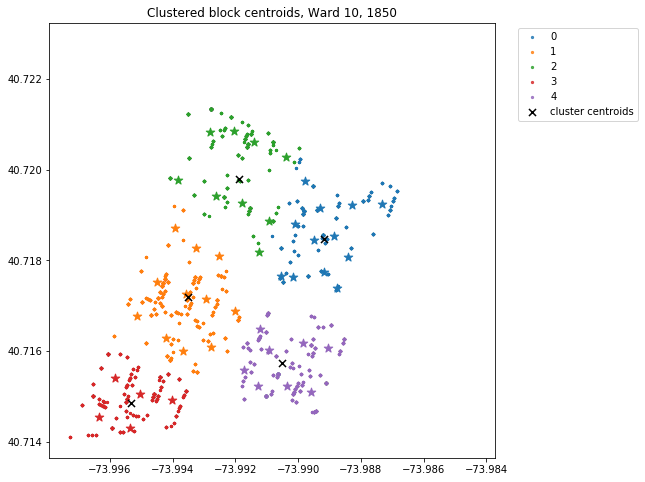

In [83]:
interpolate_enum = CentroidInterpolator(census_enumerators_seq, 10, block_boost_enum, all_cols_enum, KMeans(5), block_centroids)
score, model = interpolate_enum.kmeans_best(5)
interpolate_enum.set_clustering_algo(model)
interpolate_enum.apply_clustering(algo_fit = True)
interpolate_enum.clustervis(kmeans = True)

In [84]:
train,test = interpolate_enum.stratified_train_test()
interpolate_enum.train_test_model(train, test)

In [85]:
print("Training score:",interpolate_enum.train_score)
print("Test score:", interpolate_enum.test_score)

Training score: 1.0
Test score: 0.4924924924924925


In [86]:
## Cross validation
interpolate_enum.cross_validate_model(k=10)
print('Cross Validation')
print("avg Training score:", np.array(interpolate_enum.train_score).mean())
print('Test score:', interpolate_enum.test_score)
print("avg Test score:", np.array(interpolate_enum.test_score).mean())

Cross Validation
avg Training score: 1.0
Test score: [0.4924924924924925, 0.32820097244732577, 0.36603088101725706, 0.4099585062240664, 0.4054982817869416, 0.5049594229035167, 0.40375203915171287, 0.5143325143325144, 0.30873087308730873, 0.40033783783783783]
avg Test score: 0.41342938212809743


#### Let's try including distance based sequence id, and dwelling based sequences too

In [87]:
census_enumerators_seq = CensusData(ward10_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, block_col =  block_col, x_col = x_col, y_col = y_col)
census_enumerators_seq.apply_sequencing(enumerator = True, distance = True, dwelling = True)

In [88]:
all_cols_enum = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB","CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ', "sequence_order_enum", "sequence_id", "dwelling_seq_id", "CENSUS_ENUMERATOR_NUM", "CENSUS_ENUMERATOR_DATE", "ANCESTRY_REF", "enum_seq"]
block_boost_enum = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB","CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ', "sequence_order_enum", "sequence_id", "dwelling_seq_id", "CENSUS_ENUMERATOR_NUM", "CENSUS_ENUMERATOR_DATE", "ANCESTRY_REF", "enum_seq"])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 50))])

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


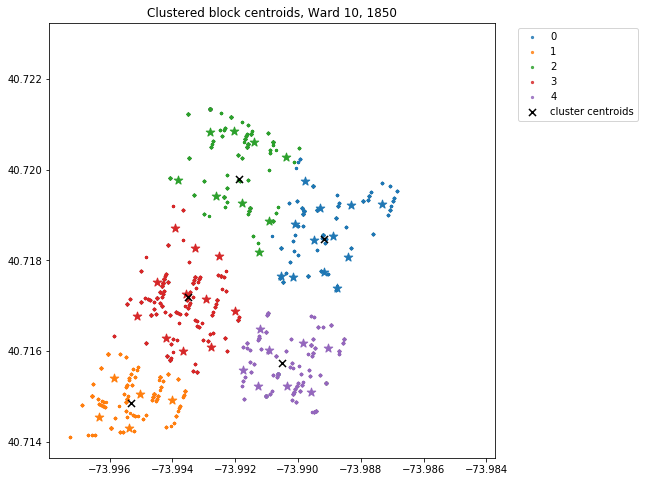

In [89]:
interpolate_enum = CentroidInterpolator(census_enumerators_seq, 10, block_boost_enum, all_cols_enum, KMeans(5), block_centroids)
score, model = interpolate_enum.kmeans_best(5)
interpolate_enum.set_clustering_algo(model)
interpolate_enum.apply_clustering(algo_fit = True)
interpolate_enum.clustervis(kmeans = True)

In [90]:
train,test = interpolate_enum.stratified_train_test()
interpolate_enum.train_test_model(train, test)

In [91]:
print("Training score:",interpolate_enum.train_score)
print("Test score:", interpolate_enum.test_score)

Training score: 1.0
Test score: 0.625438596491228


In [92]:
## Cross validation
interpolate_enum.cross_validate_model(k=10)
print('Cross Validation')
print("avg Training score:", np.array(interpolate_enum.train_score).mean())
print('Test score:', interpolate_enum.test_score)
print("avg Test score:", np.array(interpolate_enum.test_score).mean())

Cross Validation
avg Training score: 1.0
Test score: [0.625438596491228, 0.5028112449799197, 0.45113524185587367, 0.49124270225187655, 0.5721311475409836, 0.5161839863713799, 0.38953488372093026, 0.5662172878667724, 0.580068143100511, 0.48509933774834435]
avg Test score: 0.5179862571927819


#### Let's try incorporating distances into the enumerator and date based sequences

In [93]:
census_enum_seq = CensusData(ward10_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, block_col =  block_col, x_col = x_col, y_col = y_col, pagenum = pagenum)
census_enum_seq.apply_sequencing(enumerator_dist = True, dwelling = True, fixed = True, distance = True)

In [94]:
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL","sequence_order_enum", 'CENSUS_DWELLING_SEQ', "dwelling_seq_id", "fixed_seq", "enum_dist_id", "enum_dist_order"]
block_boost = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",  "sequence_order_enum", 'CENSUS_DWELLING_SEQ', "dwelling_seq_id", "fixed_seq", "enum_dist_id", "enum_dist_order"])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 50))])

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


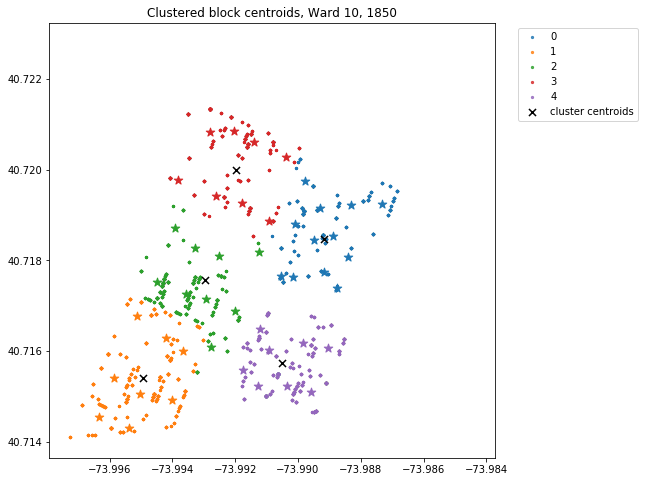

In [95]:
interpolate_sequences = CentroidInterpolator(census_enum_seq, 10, block_boost, all_cols, KMeans(5), block_centroids)
score, model = interpolate_sequences.kmeans_best(5)
interpolate_sequences.set_clustering_algo(model)
interpolate_sequences.apply_clustering(algo_fit = True)
interpolate_sequences.clustervis(kmeans = True)

In [96]:
train,test = interpolate_sequences.stratified_train_test()
interpolate_sequences.train_test_model(train, test)

In [97]:
print("Training score:",interpolate_sequences.train_score)
print("Test score:", interpolate_sequences.test_score)

Training score: 1.0
Test score: 0.6518254674977738


In [98]:
## Cross validation
interpolate_sequences.cross_validate_model(k=10)
print('Cross Validation')
print("avg Training score:", np.array(interpolate_sequences.train_score).mean())
print('Test score:', interpolate_sequences.test_score)
print("avg Test score:", np.array(interpolate_sequences.test_score).mean())

Cross Validation
avg Training score: 1.0
Test score: [0.6518254674977738, 0.5217391304347826, 0.5821167883211679, 0.49917627677100496, 0.5073637702503682, 0.5250447227191414, 0.5042955326460481, 0.5131938125568699, 0.4470046082949309, 0.5025466893039049]
avg Test score: 0.5254306798795992


#### Ordinal encode enumerator_dist order

In [8]:
# census_enum_seq = CensusData(ward10_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, block_col =  block_col, x_col = x_col, y_col = y_col, pagenum = pagenum)
# census_enum_seq.apply_sequencing(enumerator_dist = True, dwelling = True, fixed = True, distance = True)

In [9]:
# all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL","sequence_order_enum", 'CENSUS_DWELLING_SEQ', "dwelling_seq_id", "fixed_seq", "enum_dist_id", "enum_dist_order"]
# ordinal_encode = make_column_transformer((OrdinalEncoder(), ["enum_dist_order"]))
# block_boost_ord = Pipeline([('ordinal encode', ordinal_encode),
#     ('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL","sequence_order_enum", 'CENSUS_DWELLING_SEQ', "dwelling_seq_id", "fixed_seq", "enum_dist_id"])),
#     ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 50))])

In [12]:
# interpolate_sequences = CentroidInterpolator(census_enum_seq, 10, block_boost_ord, all_cols, KMeans(5), block_centroids)
# score, model = interpolate_sequences.kmeans_best(5)
# interpolate_sequences.set_clustering_algo(model)
# interpolate_sequences.apply_clustering(algo_fit = True)
# interpolate_sequences.clustervis(kmeans = True)

In [ ]:
# train,test = interpolate_sequences.stratified_train_test()
# interpolate_sequences.train_test_model(train, test)

In [ ]:
# print("Training score:",interpolate_sequences.train_score)
# print("Test score:", interpolate_sequences.test_score)

#### Let's try only enumerator_dist

In [105]:
census_enum_seq = CensusData(ward10_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, block_col = block_col, x_col = x_col, y_col = y_col, pagenum = pagenum)
census_enum_seq.apply_sequencing(enumerator_dist = True, d = 0.05)

In [106]:
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL", 'CENSUS_DWELLING_SEQ', "enum_dist_id", "enum_dist_order"]
block_boost = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",  'CENSUS_DWELLING_SEQ', "enum_dist_id", "enum_dist_order"])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 50))])

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


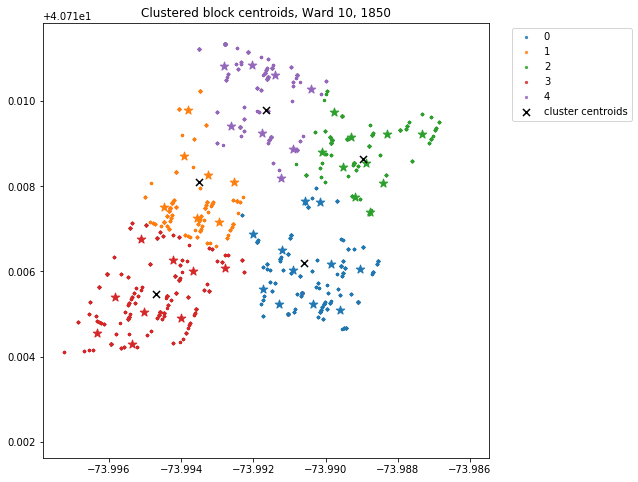

In [107]:
interpolate_sequences = CentroidInterpolator(census_enum_seq, 10, block_boost, all_cols, KMeans(5), block_centroids)
score, model = interpolate_sequences.kmeans_best(5)
interpolate_sequences.set_clustering_algo(model)
interpolate_sequences.apply_clustering(algo_fit = True)
interpolate_sequences.clustervis(kmeans = True)

In [108]:
train,test = interpolate_sequences.stratified_train_test()
interpolate_sequences.train_test_model(train, test)

In [109]:
print("Training score:",interpolate_sequences.train_score)
print("Test score:", interpolate_sequences.test_score)

Training score: 1.0
Test score: 0.6353887399463807


In [110]:
## Cross validation
interpolate_sequences.cross_validate_model(k=10)
print('Cross Validation')
print("avg Training score:", np.array(interpolate_sequences.train_score).mean())
print('Test score:', interpolate_sequences.test_score)
print("avg Test score:", np.array(interpolate_sequences.test_score).mean())

Cross Validation
avg Training score: 1.0
Test score: [0.6353887399463807, 0.49672591206735267, 0.5766871165644172, 0.5536159600997507, 0.5517841601392516, 0.46959459459459457, 0.4362745098039216, 0.5867480383609416, 0.6414141414141414, 0.54739336492891]
avg Test score: 0.5495626537919662


It's somewhat interesting that this doesn't really improve on distance sequences, since they are more intuitively created, perhaps it's because even if the distance sequence don't match exactly with the enumerator patterns, what they do do is account for geography well?

In [78]:
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL", 'CENSUS_DWELLING_SEQ', "enum_dist_id", "enum_dist_order"]
ordinal_encode = make_column_transformer((OrdinalEncoder(), ["enum_dist_order"]))
block_boost_ord = Pipeline([('ordinal encode', ordinal_encode),
    ('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL", 'CENSUS_DWELLING_SEQ', "enum_dist_id"])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 50))])

In [79]:
census_enum_seq.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23101 entries, 0 to 23100
Data columns (total 43 columns):
block_num                  5833 non-null float64
CD_ADDRESS                 5833 non-null object
cd_X                       5833 non-null float64
cd_Y                       5833 non-null float64
CENSUS_AGE                 23101 non-null int64
CENSUS_CITY                23101 non-null int64
CENSUS_DWELLING_NUM        23101 non-null float64
CENSUS_DWELLING_SEQ        23005 non-null float64
CENSUS_DWELLING_SIZE       23101 non-null int64
CENSUS_GEOG                23054 non-null object
CENSUS_HH_NUM              23101 non-null int64
CENSUS_ID                  545 non-null object
CENSUS_IMPREL              23101 non-null int64
CENSUS_INDEX               23101 non-null int64
CENSUS_IPUMS_UID           23101 non-null object
CENSUS_LABFORCE            23101 non-null int64
CENSUS_LINE                23101 non-null int64
CENSUS_MARST               23101 non-null int64
CENSUS_NAMEFRST    

In [85]:
# interpolate_sequences = CentroidInterpolator(census_enum_seq, 10, block_boost_ord, all_cols, KMeans(5), block_centroids)
# score, model = interpolate_sequences.kmeans_best(5)
# interpolate_sequences.set_clustering_algo(model)
# interpolate_sequences.apply_clustering()
# interpolate_sequences.clustervis(kmeans = True)

In [ ]:
# train,test = interpolate_sequences.stratified_train_test()
# interpolate_sequences.train_test_model(train, test)

In [ ]:
# print("Training score:",interpolate_sequences.train_score)
# print("Test score:", interpolate_sequences.test_score)

#### Let's look at the distributions of some of these values

In [86]:
census_enum_distr = CensusData(ward10_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, block_col =  block_col, x_col = x_col, y_col = y_col)
census_enum_distr.apply_sequencing(enumerator_dist = True)

activate


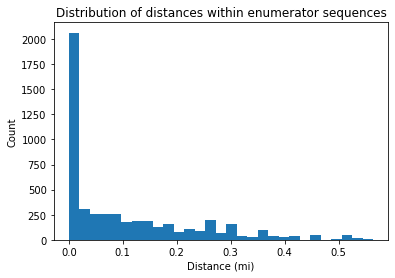

In [92]:
plt.hist(census_enum_distr.df["enum_dist"], bins = "auto")
plt.title("Distribution of distances within enumerator sequences")
plt.xlabel("Distance (mi)")
plt.ylabel("Count")
plt.show()

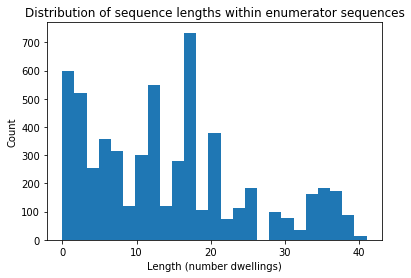

In [88]:
plt.hist(census_enum_distr.df["enum_sequence_len"], bins = "auto")
plt.title("Distribution of sequence lengths within enumerator sequences")
plt.xlabel("Length (number dwellings)")
plt.ylabel("Count")
plt.show()

In [89]:
census_seq_dist = CensusData(ward10_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, block_col =  block_col, x_col = x_col, y_col = y_col)
census_seq_dist.apply_sequencing(distance = True, d = 0.05)

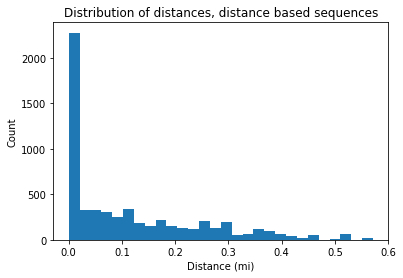

In [90]:
plt.hist(census_seq_dist.df["dist"], bins = "auto")
plt.title("Distribution of distances, distance based sequences")
plt.xlabel("Distance (mi)")
plt.ylabel("Count")
plt.show()

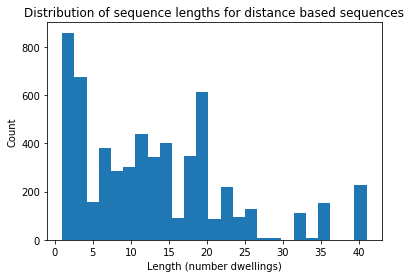

In [91]:
plt.hist(census_seq_dist.df["sequence_len"], bins = "auto")
plt.title("Distribution of sequence lengths for distance based sequences")
plt.xlabel("Length (number dwellings)")
plt.ylabel("Count")
plt.show()